In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Download library

In [ ]:
!pip install fairseq
!pip install fastBPE          # Using byte pair encoding (subwords)
!pip install pyvi             # Using tokenizer Vietnamese language
!pip install sentence_transformers  # SOTA sentence embedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.5/286.5 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11291804 sha256=da010d8134f1c36f86b4976d353766827763b2392fe0ca1edb4771c1fa575c97
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=1

In [ ]:
# Download config Phobert VinAI
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2023-10-05 08:47:01--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.162.17, 52.84.162.15, 52.84.162.36, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.162.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M  23.5MB/s    in 15s     

2023-10-05 08:47:17 (21.1 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


# Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse
import re
from pyvi import ViTokenizer
import torch
import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn
from keras.utils import pad_sequences
from scipy import spatial
from tqdm import tqdm
from sentence_transformers import SentenceTransformer   # Pretrained model embeddings in module sentence_transformers
from sentence_transformers import util

In [ ]:
# Config encoding subwords
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes',
    default="/content/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)   # BPE encode

# Load the dictionary for encoding subwords
vocab = Dictionary()
vocab.add_from_file("/content/PhoBERT_base_transformers/dict.txt")

# EDA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Skymap/Text Retrieval/data/shuffle_small_query.csv')
data.head()

,Unnamed: 0,title,query
0,176,"Điều 429: Bảo đảm quyền chuyển tiền, tài sản t...",Nếu bên ngoại yêu cầu thêm thông tin hay chứng...
1,36,Điều 411: Trình tự phiên họp xét tính hợp pháp...,Thẩm phán chủ trì phiên họp xét tính hợp pháp ...
2,237,"Điều 476: Thông báo về việc thụ lý, ngày mở ph...",Có quy định gì về thời gian mở lại phiên họp g...
3,393,Điều 354: Người có thẩm quyền kháng nghị theo ...,"Khi bản án, quyết định đã có hiệu lực pháp luậ..."
4,330,Điều 368: Quyết định việc thay đổi người tiến ...,Trong tình huống nào Chánh án của Tòa án quyết...


In [ ]:
data.shape

(470, 3)

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,title,query
0,"Điều 429: Bảo đảm quyền chuyển tiền, tài sản t...",Nếu bên ngoại yêu cầu thêm thông tin hay chứng...
1,Điều 411: Trình tự phiên họp xét tính hợp pháp...,Thẩm phán chủ trì phiên họp xét tính hợp pháp ...
2,"Điều 476: Thông báo về việc thụ lý, ngày mở ph...",Có quy định gì về thời gian mở lại phiên họp g...
3,Điều 354: Người có thẩm quyền kháng nghị theo ...,"Khi bản án, quyết định đã có hiệu lực pháp luậ..."
4,Điều 368: Quyết định việc thay đổi người tiến ...,Trong tình huống nào Chánh án của Tòa án quyết...


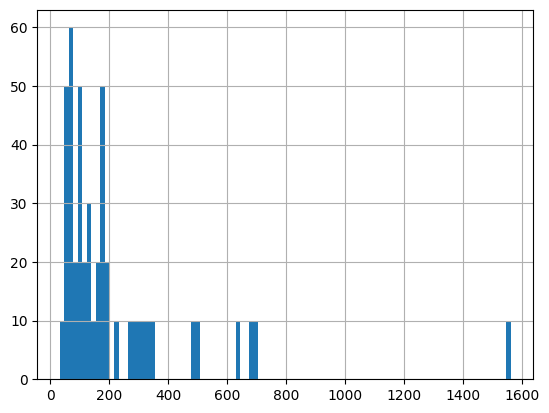

In [ ]:
seq_len_title = [len(title.split()) for title in data['title']]
pd.Series(seq_len_title).hist(bins=100)
plt.show()

In [ ]:
print(max(seq_len_title), min(seq_len_title))

1562 33


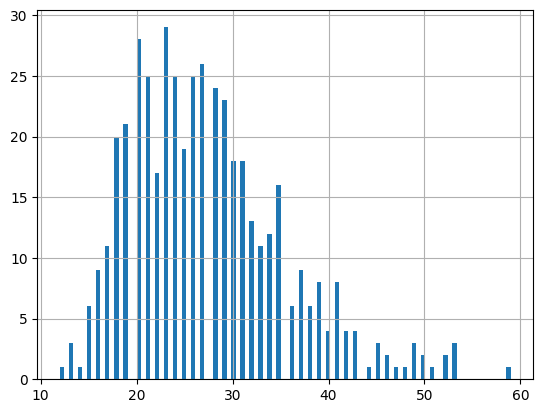

In [ ]:
seq_len_query = [len(query.split()) for query in data['query']]
pd.Series(seq_len_query).hist(bins=100)
plt.show()

In [ ]:
print(max(seq_len_query), min(seq_len_query))

59 12


# Preprocessing + Tokenize

In [ ]:
def lower_str(text):
  return text.lower()

def remove_all_punctuation(text: str):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punctuation = text.translate(translator)
    return text_no_punctuation

def remove_stopword(text):
  pass

def preprocessing(text):
  text = lower_str(text)
  text = remove_all_punctuation(text)
  return text

In [ ]:
for i in range(len(data)):
  data['title'][i] = ViTokenizer.tokenize(preprocessing(data['title'][i]))
  data['query'][i] = ViTokenizer.tokenize(preprocessing(data['query'][i]))

data.head()

,title,query
0,điều 429 bảo_đảm quyền chuyển tiền_tài_sản thi...,nếu bên ngoại yêu_cầu thêm thông_tin hay chứng...
1,điều 411 trình_tự phiên họp xét tính hợp_pháp ...,thẩm_phán chủ_trì phiên họp xét tính hợp_pháp ...
2,điều 476 thông_báo về việc thụ_lý ngày mở phiê...,có quy_định gì về thời_gian mở lại phiên họp g...
3,điều 354 người có thẩm_quyền kháng_nghị theo t...,khi bản_án quyết_định đã có hiệu_lực pháp_luật...
4,điều 368 quyết_định việc thay_đổi người tiến_h...,trong tình_huống nào chánh_án của tòa_án quyết...


# Encoding

In [ ]:
titles = []
for i in range(len(data)):
  titles.append(data['title'][i])

querys = []
for i in range(len(data)):
  querys.append(data['query'][i])

In [ ]:
titles = list(set(titles))
print(len(titles))

44


In [ ]:
max_seq_length_title = 256 # 256, 128
from torch.nn.utils.rnn import pad_sequence
#max_seq_length_title = 1600
def encoding_subwords(sents, vocab, bpe):
  input_ids = []
  for sent in sents:
    subwords = bpe.encode('<s> ' + sent + ' </s>')    # add token cls, eos
    encoded_sent = vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist()
    encode_tensor = torch.tensor(encoded_sent)
    input_ids.append(encode_tensor)

  input_ids = pad_sequence(input_ids)
  #input_ids = pad_sequences(input_ids, maxlen=max_seq_length_title, dtype="long", value=0, truncating="post", padding="post")
  return input_ids

In [ ]:
title_ids = encoding_subwords(titles, vocab, bpe)
#title_ids = torch.tensor(title_ids, dtype=torch.float)
#title_ids = torch.tensor(title_ids)

# Embedding

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')   # SOTA words embedding (pretrained)

In [ ]:
title_embeddings = model.encode(titles, convert_to_tensor=True)    # 384 dimensional dense vector space
print(title_embeddings)

tensor([[-2.1311e-02,  1.2804e-02,  3.5883e-02,  ...,  6.1226e-02,
         -9.3956e-03, -1.5937e-03],
        [-3.2465e-02,  6.1214e-03,  3.6712e-02,  ...,  1.0727e-01,
         -3.2218e-02, -4.2942e-03],
        [-1.9711e-02, -5.9621e-03,  3.0714e-02,  ...,  5.6491e-02,
         -1.6082e-02,  3.6926e-05],
        ...,
        [-3.7672e-02, -1.2571e-02,  3.6764e-02,  ...,  9.1827e-02,
         -2.9631e-02, -3.3238e-02],
        [-3.9190e-02, -4.7329e-02,  1.2901e-02,  ...,  9.3774e-02,
         -4.1592e-02, -4.2208e-03],
        [-7.2325e-02, -3.1638e-02,  8.6827e-03,  ...,  6.4411e-02,
         -4.4041e-02,  2.2735e-02]], device='cuda:0')


# Inference

In [ ]:
# Metric: Cosine similarity
def similarity(query_embeddings, corpus_embeddings):
  return util.cos_sim(query_embeddings, corpus_embeddings)[0]

In [ ]:
def ranking(query, top_k=10):
  query_embeddings = model.encode(query, convert_to_tensor=True)
  #query_embeddings = torch.tensor(encoding_subwords(query, vocab, bpe), dtype=torch.float)
  #query_embeddings = query_embeddings.unsqueeze(0)
  #query_embeddings = torch.tensor(convert_lines(query, vocab, bpe), dtype=torch.float)
  #query_embeddings = torch.tensor(test_encoding_subwords(query, vocab, bpe), dtype=torch.float)
  cos_scores = similarity(query_embeddings, title_embeddings,
                          #title_ids
                          )
  #print(cos_scores)
  top_results = torch.topk(cos_scores, k=top_k)
  return top_results

## Inference in query column


In [ ]:
#custom_queries = [querys[1]]  # Max score: 0.8681  (rank 4th)
#custom_queries = [querys[2]]   # Max score: 0.7380 (rank 9th)
#custom_queries = [querys[3]]    # Max score: 0.8536 (rank 2nd)
custom_queries = [querys[4]]      # Max score: 0.8239 (rank 1st)

top_k = 10
for query in custom_queries:
  top_results = ranking(query, top_k)
  #print(top_results)
  print("Query: ", query)
  print("\n=====================")
  print(f"Top {top_k} most similar sentences in corpus:\n")

  for idx, (score, doc_idx) in enumerate(zip(top_results[0], top_results[1])):
    print(f'Document rank {idx + 1}:')
    print(titles[doc_idx], f'\n(Score: {score:.4f})', '\n')

Query:  trong tình_huống nào chánh_án của tòa_án quyết_định thay_đổi thẩm_phán hoặc thư_ký phiên họp khi giải_quyết việc dân_sự

Top 10 most similar sentences in corpus:

Document rank 1:
điều 368 quyết_định việc thay_đổi người tiến_hành tố_tụng khi giải_quyết việc dân_sự trước khi mở phiên họp việc thay_đổi thẩm_phán thư_ký phiên họp do chánh_án của tòa_án đang giải_quyết việc dân_sự đó quyết_định nếu thẩm_phán bị thay_đổi là chánh_án của tòa_án đang giải_quyết việc dân_sự đó thì việc thay_đổi do chánh_án tòa_án trên một cấp trực_tiếp quyết_định tại phiên họp giải_quyết việc dân_sự_việc thay_đổi thẩm_phán thư_ký phiên họp được thực_hiện như sau trường_hợp việc dân_sự do một thẩm_phán giải_quyết thì việc thay_đổi thẩm_phán thư_ký phiên họp do chánh_án của tòa_án đang giải_quyết việc dân_sự đó quyết_định nếu thẩm_phán bị thay_đổi là chánh_án của tòa_án đang giải_quyết việc dân_sự đó thì việc thay_đổi do chánh_án tòa_án trên một cấp trực_tiếp quyết_định trường_hợp việc dân_sự do hội_đồng

## Inference hands-on

In [ ]:
#hand_queries = ['tìm kiếm người vắng mặt tại nơi cư trú']   # dieu 383, 385
hand_queries = ['Thẩm quyền của Tòa án theo lãnh thổ']        # Dieu 39

top_k = 10
for query in hand_queries:
  query = ViTokenizer.tokenize(preprocessing(query))
  print(query)
  top_results = ranking(query, top_k)
  #print(top_results)
  print("Query: ", query)
  print("\n=====================")
  print(f"Top {top_k} most similar sentences in corpus:\n")

  for idx, (score, doc_idx) in enumerate(zip(top_results[0], top_results[1])):
    print(f'Document rank {idx + 1}:')
    print(titles[doc_idx], f'\n(Score: {score:.4f})', '\n')

thẩm_quyền của tòa_án theo lãnh_thổ
Query:  thẩm_quyền của tòa_án theo lãnh_thổ

Top 10 most similar sentences in corpus:

Document rank 1:
điều 405 thẩm_quyền xét tính hợp_pháp của cuộc đình_công tòa_án nhân_dân cấp tỉnh nơi xảy ra đình_công có thẩm_quyền xét tính hợp_pháp của cuộc đình_công tòa_án nhân_dân cấp cao có thẩm_quyền giải_quyết kháng_cáo kháng_nghị đối_với quyết_định của tòa_án nhân_dân cấp tỉnh về tính hợp_pháp của cuộc đình_công trong phạm_vi thẩm_quyền theo lãnh_thổ 
(Score: 0.6255) 

Document rank 2:
điều 355 thời_hạn kháng_nghị theo thủ_tục tái_thẩm thời_hạn kháng_nghị theo thủ_tục tái_thẩm là 01 năm kể từ ngày người có thẩm_quyền kháng_nghị biết được căn_cứ để kháng_nghị theo thủ_tục tái_thẩm quy_định tại điều 352 của bộ_luật này 
(Score: 0.6220) 

Document rank 3:
điều 509 người có quyền tố_cáo cá_nhân có quyền tố_cáo với cơ_quan tổ_chức cá_nhân có thẩm_quyền về hành_vi vi_phạm_pháp_luật của người có thẩm_quyền tiến_hành tố_tụng gây thiệt_hại hoặc đe_dọa gây thiệt_h